<h1> <center> Amazon Fake Reviews </center> </h1>

In [1]:
#!pip install langdetect
#!pip install language_check

In [2]:
#General purpose
import os
#Data handling
import pandas as pd
import numpy as np
import datetime
import re
#Data Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 
#Modelling 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from langdetect import detect #to filter non-english reviews.
import language_check #to detect errors
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler

In [3]:
## nltk downloads
# nltk.download('punkt') # At first you have to download these nltk packages.
# nltk.download('stopwords')
# nltk.download('wordnet')
stop_words=stopwords.words('english')

In [4]:
#Load dataset
df=pd.read_csv('../data/exports/test_appliances.csv')
df.head()

,asin,reviewDate,reviewerID,reviewerName,reviewTitle,productGradeByReview,reviewText,reviewUpvotes,reviewHasImage,reviewIsVerified,...,productTitle,productDescription,productFeatures,productHasImage,productCategory,productBrand,productRank,productYear,productMonth,productDay
0,B00009W3I4,2013-08-22,A34A1UP40713F8,James. Backus,Great product,5,I like this as a vent as well as something tha...,0,0,1,...,HEARTLAND 21000 Energy Saving Dryer Vent Closure,Replace your old vent with the Heartland Natur...,EASY-TO-INSTALL Dryer vent closure with hassl...,1.0,Tools & Home Improvement,HEARTLAND,5633.0,2003.0,5.0,14.0
1,B00009W3PA,2016-02-08,A1AHW6I678O6F2,kevin.,Five Stars,5,good item,0,0,1,...,Certified Appliance Accessories 3-Wire Closed-...,Some people are surprised to learn that a new ...,250 volt,1.0,Tools & Home Improvement,Certified Appliance Accessories,135619.0,2006.0,5.0,26.0
2,B00009W3PA,2015-08-05,A8R48NKTGCJDQ,CDBrannom,Five Stars,5,Fit my new LG dryer perfectly.,0,0,1,...,Certified Appliance Accessories 3-Wire Closed-...,Some people are surprised to learn that a new ...,250 volt,1.0,Tools & Home Improvement,Certified Appliance Accessories,135619.0,2006.0,5.0,26.0
3,B00009W3PA,2015-04-24,AR3OHHHW01A8E,Calvin E Reames,Perfect size,5,Good value for electric dryers,0,0,1,...,Certified Appliance Accessories 3-Wire Closed-...,Some people are surprised to learn that a new ...,250 volt,1.0,Tools & Home Improvement,Certified Appliance Accessories,135619.0,2006.0,5.0,26.0
4,B00009W3PA,2015-03-21,A2CIEGHZ7L1WWR,albert j. kong,Five Stars,5,Price and delivery was excellent.,0,0,1,...,Certified Appliance Accessories 3-Wire Closed-...,Some people are surprised to learn that a new ...,250 volt,1.0,Tools & Home Improvement,Certified Appliance Accessories,135619.0,2006.0,5.0,26.0


In [5]:
df.columns

Index(['asin', 'reviewDate', 'reviewerID', 'reviewerName', 'reviewTitle',
       'productGradeByReview', 'reviewText', 'reviewUpvotes', 'reviewHasImage',
       'reviewIsVerified', 'reviewYear', 'reviewMonth', 'reviewDay',
       'productDate', 'productTitle', 'productDescription', 'productFeatures',
       'productHasImage', 'productCategory', 'productBrand', 'productRank',
       'productYear', 'productMonth', 'productDay'],
      dtype='object')

# Useful functions

In [6]:
#Print review
def print_review(df,i):
    print('-------------------')
    print('Review #{}'.format(i))
    print('Title: {},\nReview: {},\nReviewer ID: {},\nVerified: {}'
          .format(df['reviewTitle'][i], df['reviewText'][i], df['reviewerID'][i], df['reviewIsVerified'][i]))
    

In [7]:
#Print product
def print_product(df,i):
    print('-------------------')
    print('Product: {}'.format(df['asin'][i]))
    print('Name: {},\nCategory: {},\nRank: {},\nBrand: {}\nDescription: {}'
         .format(df['productTitle'][i],df['productCategory'][i],df['productRank'][i],df['productBrand'][i],df['productDescription'][i]))
#ToDo
#Modify to be able to get and print a product by its ID

In [8]:
#Cosine Similarity
def cosine_sim_vectors(vec1,vec2):
    vec1=vec1.reshape(1,-1)
    vec2=vec2.reshape(1,-1)
    
    return cosine_similarity(vec1,vec2)[0][0]

In [9]:
#Print error
def print_error(matches,i):
    error=matches[i]
    print('-------------------')
    print('Rule ID: ',error.ruleId)
    print('Category: ',error.category)
    print('Error and context: ',error.context)
    print(error.msg)

In [10]:
#Manage errors
def manage_errors(text,matches=None):
    if matches is None:
        matches=language_check.LanguageTool('en-US').check(text)
    mistakes=[]
    corrections=[]
    error_start=[]
    error_end=[]
    
    for error in matches:
        if len(error.replacements)>0:
            error_start.append(error.offset)
            error_end.append(error.offset+error.errorlength)
            mistakes.append(text[error_start[-1]:error_end[-1]])
            corrections.append(error.replacements[0])
            
    #return list(zip(mistakes,corrections,error_start,error_end))
    return mistakes,corrections,error_start,error_end

In [11]:
#Correct errors
def correct_errors(text,matches=None, mistakes=None,corrections=None,start=None, end=None):
    
    if end is None:
        mistakes,corrections,start,end=manage_errors(text,matches)
        
    corrected_text=list(text)
    
    for i in range(len(start)):
        for j in range(len(text)):
            if (j>start[i] and j<end[i]):
                corrected_text[j]=""
            
        corrected_text[start[i]]=corrections[i]
        
    return "".join(corrected_text)
        

In [12]:
def text_preprocessing(text):
    
    # data cleaning
    text = re.sub(re.compile('<.*?>'), '', text) #removing html tags
    text =  re.sub('[^A-Za-z0-9]+', ' ', text) #taking only words

    # lowercase
    text = text.lower()

    # tokenization
    tokens = nltk.word_tokenize(text) # converts text to tokens

    # stop_words removal
    text = [word for word in tokens if word not in stop_words] #removing stop words

    # lemmatization
    text = [WordNetLemmatizer().lemmatize(word) for word in text]

    # join words in preprocessed text
    text = ' '.join(text)

    return text

# Data Analysis

In [13]:
df.dtypes

asin                     object
reviewDate               object
reviewerID               object
reviewerName             object
reviewTitle              object
productGradeByReview      int64
reviewText               object
reviewUpvotes             int64
reviewHasImage            int64
reviewIsVerified          int64
reviewYear                int64
reviewMonth               int64
reviewDay                 int64
productDate              object
productTitle             object
productDescription       object
productFeatures          object
productHasImage         float64
productCategory          object
productBrand             object
productRank             float64
productYear             float64
productMonth            float64
productDay              float64
dtype: object

* reviewDate and productDate should be changed to datetime
* The categorical variables (productGradeByReview, reviewUpvotes*, reviewHasImage, reviewIsVerified could be change temporarily to float to use the Pandas Describe function (cf cell below)

In [14]:
df.describe(include='all')

,asin,reviewDate,reviewerID,reviewerName,reviewTitle,productGradeByReview,reviewText,reviewUpvotes,reviewHasImage,reviewIsVerified,...,productTitle,productDescription,productFeatures,productHasImage,productCategory,productBrand,productRank,productYear,productMonth,productDay
count,2277,2277,2277,2277,2277,2277.000000,2277,2277.000000,2277.000000,2277.000000,...,2275,190,2245,2275.000000,2275,2275,2.274000e+03,2275.000000,2275.000000,2275.000000
unique,48,99,47,47,96,NaN,144,NaN,NaN,NaN,...,46,41,40,NaN,5,26,NaN,NaN,NaN,NaN
top,B0006GVNOA,2016-12-06,AMY6O4Z9HINO0,Ann,Worked like a charm,NaN,first thing first: it works. the kit is great ...,NaN,NaN,NaN,...,Gardus RLE202 LintEater Rotary Dryer Vent Clea...,Constructed of 4-ply aluminum foil laminate. F...,Most valuable tool you can own to ensure the s...,NaN,Tools &amp; Home Improvement,LintEater,NaN,NaN,NaN,NaN
freq,2040,412,206,206,206,NaN,206,NaN,NaN,NaN,...,2040,12,2064,NaN,2040,2064,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,4.499780,NaN,221.378568,0.363636,0.987264,...,NaN,NaN,NaN,0.952527,NaN,NaN,6.880796e+03,2001.767473,4.291868,7.040879
std,NaN,NaN,NaN,NaN,NaN,0.837723,NaN,542.987888,0.481151,0.112158,...,NaN,NaN,NaN,0.212694,NaN,NaN,4.348922e+04,72.809410,1.185184,4.175630
min,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,0.000000,NaN,NaN,1.000000e+00,-1.000000,-1.000000,-1.000000
25%,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,5.000000,0.000000,1.000000,...,NaN,NaN,NaN,1.000000,NaN,NaN,1.976000e+03,2004.000000,4.000000,6.000000
50%,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,8.000000,0.000000,1.000000,...,NaN,NaN,NaN,1.000000,NaN,NaN,1.976000e+03,2004.000000,4.000000,6.000000
75%,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,165.000000,1.000000,1.000000,...,NaN,NaN,NaN,1.000000,NaN,NaN,1.976000e+03,2004.000000,4.000000,6.000000


* The dataset contains 2277 reviews for 48 different products and from 47 different reviewers
* The categorical variables are not analyzed properly with the describe method => A solution would be to convert them to float
* 75% of the reviews assign a grade of 5 to the products
* We know from before that most of the reviews are verified with a ratio around 1000/1.


In [15]:
#Confirming that we have reviews for only 48 products
df['asin'].value_counts().shape

(48,)

In [16]:
df['asin'].value_counts().head()

B0006GVNOA    2040
B0014CN8Y8      24
B00JGTUQJ6      13
B0015UGPWQ      12
B00CW0O1EW       8
Name: asin, dtype: int64

In [17]:
#Let's examine this product
temp=df[df['asin']=='B0006GVNOA'].head(1).reset_index()
print_product(temp,0)

-------------------
Product: B0006GVNOA
Name: Gardus RLE202 LintEater Rotary Dryer Vent Cleaning System,
Category: Tools &amp; Home Improvement,
Rank: 1976.0,
Brand: LintEater
Description: nan


# Data Processing

## Filtering on English reviews

In [18]:
df['reviewLang']=df['reviewText'].apply(lambda x : detect(x)) 
df.head()

,asin,reviewDate,reviewerID,reviewerName,reviewTitle,productGradeByReview,reviewText,reviewUpvotes,reviewHasImage,reviewIsVerified,...,productDescription,productFeatures,productHasImage,productCategory,productBrand,productRank,productYear,productMonth,productDay,reviewLang
0,B00009W3I4,2013-08-22,A34A1UP40713F8,James. Backus,Great product,5,I like this as a vent as well as something tha...,0,0,1,...,Replace your old vent with the Heartland Natur...,EASY-TO-INSTALL Dryer vent closure with hassl...,1.0,Tools & Home Improvement,HEARTLAND,5633.0,2003.0,5.0,14.0,en
1,B00009W3PA,2016-02-08,A1AHW6I678O6F2,kevin.,Five Stars,5,good item,0,0,1,...,Some people are surprised to learn that a new ...,250 volt,1.0,Tools & Home Improvement,Certified Appliance Accessories,135619.0,2006.0,5.0,26.0,en
2,B00009W3PA,2015-08-05,A8R48NKTGCJDQ,CDBrannom,Five Stars,5,Fit my new LG dryer perfectly.,0,0,1,...,Some people are surprised to learn that a new ...,250 volt,1.0,Tools & Home Improvement,Certified Appliance Accessories,135619.0,2006.0,5.0,26.0,en
3,B00009W3PA,2015-04-24,AR3OHHHW01A8E,Calvin E Reames,Perfect size,5,Good value for electric dryers,0,0,1,...,Some people are surprised to learn that a new ...,250 volt,1.0,Tools & Home Improvement,Certified Appliance Accessories,135619.0,2006.0,5.0,26.0,en
4,B00009W3PA,2015-03-21,A2CIEGHZ7L1WWR,albert j. kong,Five Stars,5,Price and delivery was excellent.,0,0,1,...,Some people are surprised to learn that a new ...,250 volt,1.0,Tools & Home Improvement,Certified Appliance Accessories,135619.0,2006.0,5.0,26.0,en


In [19]:
df['reviewLang'].value_counts()

en    2236
so      15
ro       7
hu       5
de       4
id       2
cs       2
pl       1
sk       1
sl       1
ca       1
af       1
et       1
Name: reviewLang, dtype: int64

In [20]:
features=df[df['reviewLang']=='en']
features.head()

,asin,reviewDate,reviewerID,reviewerName,reviewTitle,productGradeByReview,reviewText,reviewUpvotes,reviewHasImage,reviewIsVerified,...,productDescription,productFeatures,productHasImage,productCategory,productBrand,productRank,productYear,productMonth,productDay,reviewLang
0,B00009W3I4,2013-08-22,A34A1UP40713F8,James. Backus,Great product,5,I like this as a vent as well as something tha...,0,0,1,...,Replace your old vent with the Heartland Natur...,EASY-TO-INSTALL Dryer vent closure with hassl...,1.0,Tools & Home Improvement,HEARTLAND,5633.0,2003.0,5.0,14.0,en
1,B00009W3PA,2016-02-08,A1AHW6I678O6F2,kevin.,Five Stars,5,good item,0,0,1,...,Some people are surprised to learn that a new ...,250 volt,1.0,Tools & Home Improvement,Certified Appliance Accessories,135619.0,2006.0,5.0,26.0,en
2,B00009W3PA,2015-08-05,A8R48NKTGCJDQ,CDBrannom,Five Stars,5,Fit my new LG dryer perfectly.,0,0,1,...,Some people are surprised to learn that a new ...,250 volt,1.0,Tools & Home Improvement,Certified Appliance Accessories,135619.0,2006.0,5.0,26.0,en
3,B00009W3PA,2015-04-24,AR3OHHHW01A8E,Calvin E Reames,Perfect size,5,Good value for electric dryers,0,0,1,...,Some people are surprised to learn that a new ...,250 volt,1.0,Tools & Home Improvement,Certified Appliance Accessories,135619.0,2006.0,5.0,26.0,en
4,B00009W3PA,2015-03-21,A2CIEGHZ7L1WWR,albert j. kong,Five Stars,5,Price and delivery was excellent.,0,0,1,...,Some people are surprised to learn that a new ...,250 volt,1.0,Tools & Home Improvement,Certified Appliance Accessories,135619.0,2006.0,5.0,26.0,en


In [21]:
features['reviewLang'].value_counts()

en    2236
Name: reviewLang, dtype: int64

## Checking grammar and syntax errors 

In [22]:
checker = language_check.LanguageTool('en-US')

In [23]:
text="LanguageTool offers spell and grammar checking. Just paste your text here and click the ‘Check Text’ button. Click the colored phrases for details on potential errors. or use this text too see an few of of the problems that LanguageTool can detecd. What do you thinks of grammar checkers? Please not that they are not perfect. Style issues get a blue marker: It’s 5 P.M. in the afternoon. The weather was nice on Thursday, 27 June 2017"

In [24]:
matches=checker.check(text)
matches

[Match({'fromy': 0, 'fromx': 168, 'toy': 0, 'tox': 170, 'ruleId': 'UPPERCASE_SENTENCE_START', 'msg': 'This sentence does not start with an uppercase letter', 'replacements': ['Or'], 'context': '...hrases for details on potential errors. or use this text too see an few of of the ...', 'contextoffset': 43, 'offset': 168, 'errorlength': 2, 'category': 'Capitalization', 'locqualityissuetype': 'typographical'}),
 Match({'fromy': 0, 'fromx': 185, 'toy': 0, 'tox': 192, 'ruleId': 'TOO_TO', 'subId': '1', 'msg': "Did you mean 'to see'?", 'replacements': ['to see'], 'context': '...s on potential errors. or use this text too see an few of of the problems that Language...', 'contextoffset': 43, 'offset': 185, 'errorlength': 7, 'category': 'Possible Typo', 'locqualityissuetype': 'misspelling'}),
 Match({'fromy': 0, 'fromx': 193, 'toy': 0, 'tox': 195, 'ruleId': 'EN_A_VS_AN', 'msg': "Use 'a' instead of 'an' if the following word doesn't start with a vowel sound, e.g. 'a sentence', 'a university'", 're

In [25]:
len(matches)

9

In [26]:
features['reviewErrors']=features['reviewText'].apply(lambda text: checker.check(text))
features.head()

C:\Users\viann\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,asin,reviewDate,reviewerID,reviewerName,reviewTitle,productGradeByReview,reviewText,reviewUpvotes,reviewHasImage,reviewIsVerified,...,productFeatures,productHasImage,productCategory,productBrand,productRank,productYear,productMonth,productDay,reviewLang,reviewErrors
0,B00009W3I4,2013-08-22,A34A1UP40713F8,James. Backus,Great product,5,I like this as a vent as well as something tha...,0,0,1,...,EASY-TO-INSTALL Dryer vent closure with hassl...,1.0,Tools & Home Improvement,HEARTLAND,5633.0,2003.0,5.0,14.0,en,[]
1,B00009W3PA,2016-02-08,A1AHW6I678O6F2,kevin.,Five Stars,5,good item,0,0,1,...,250 volt,1.0,Tools & Home Improvement,Certified Appliance Accessories,135619.0,2006.0,5.0,26.0,en,"[Line 1, column 1, Rule ID: UPPERCASE_SENTENCE..."
2,B00009W3PA,2015-08-05,A8R48NKTGCJDQ,CDBrannom,Five Stars,5,Fit my new LG dryer perfectly.,0,0,1,...,250 volt,1.0,Tools & Home Improvement,Certified Appliance Accessories,135619.0,2006.0,5.0,26.0,en,[]
3,B00009W3PA,2015-04-24,AR3OHHHW01A8E,Calvin E Reames,Perfect size,5,Good value for electric dryers,0,0,1,...,250 volt,1.0,Tools & Home Improvement,Certified Appliance Accessories,135619.0,2006.0,5.0,26.0,en,[]
4,B00009W3PA,2015-03-21,A2CIEGHZ7L1WWR,albert j. kong,Five Stars,5,Price and delivery was excellent.,0,0,1,...,250 volt,1.0,Tools & Home Improvement,Certified Appliance Accessories,135619.0,2006.0,5.0,26.0,en,[]


In [27]:
features['reviewNbErrors']=features['reviewErrors'].apply(lambda x: len(x))
features.head()

C:\Users\viann\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,asin,reviewDate,reviewerID,reviewerName,reviewTitle,productGradeByReview,reviewText,reviewUpvotes,reviewHasImage,reviewIsVerified,...,productHasImage,productCategory,productBrand,productRank,productYear,productMonth,productDay,reviewLang,reviewErrors,reviewNbErrors
0,B00009W3I4,2013-08-22,A34A1UP40713F8,James. Backus,Great product,5,I like this as a vent as well as something tha...,0,0,1,...,1.0,Tools & Home Improvement,HEARTLAND,5633.0,2003.0,5.0,14.0,en,[],0
1,B00009W3PA,2016-02-08,A1AHW6I678O6F2,kevin.,Five Stars,5,good item,0,0,1,...,1.0,Tools & Home Improvement,Certified Appliance Accessories,135619.0,2006.0,5.0,26.0,en,"[Line 1, column 1, Rule ID: UPPERCASE_SENTENCE...",1
2,B00009W3PA,2015-08-05,A8R48NKTGCJDQ,CDBrannom,Five Stars,5,Fit my new LG dryer perfectly.,0,0,1,...,1.0,Tools & Home Improvement,Certified Appliance Accessories,135619.0,2006.0,5.0,26.0,en,[],0
3,B00009W3PA,2015-04-24,AR3OHHHW01A8E,Calvin E Reames,Perfect size,5,Good value for electric dryers,0,0,1,...,1.0,Tools & Home Improvement,Certified Appliance Accessories,135619.0,2006.0,5.0,26.0,en,[],0
4,B00009W3PA,2015-03-21,A2CIEGHZ7L1WWR,albert j. kong,Five Stars,5,Price and delivery was excellent.,0,0,1,...,1.0,Tools & Home Improvement,Certified Appliance Accessories,135619.0,2006.0,5.0,26.0,en,[],0


In [28]:
features['reviewNbErrors'].value_counts()

1     659
3     418
0     300
21    210
15    206
16    206
8     206
2      21
4       4
6       3
41      2
10      1
Name: reviewNbErrors, dtype: int64

In [29]:
def get_errorCategories(errors):
    categories=[]
    for error in errors:
        categories.append(error.category)
    return categories

In [30]:
features['reviewErrorCategories']=features['reviewErrors'].apply(lambda x: get_errorCategories(x))
features.head(10)

C:\Users\viann\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,asin,reviewDate,reviewerID,reviewerName,reviewTitle,productGradeByReview,reviewText,reviewUpvotes,reviewHasImage,reviewIsVerified,...,productCategory,productBrand,productRank,productYear,productMonth,productDay,reviewLang,reviewErrors,reviewNbErrors,reviewErrorCategories
0,B00009W3I4,2013-08-22,A34A1UP40713F8,James. Backus,Great product,5,I like this as a vent as well as something tha...,0,0,1,...,Tools & Home Improvement,HEARTLAND,5633.0,2003.0,5.0,14.0,en,[],0,[]
1,B00009W3PA,2016-02-08,A1AHW6I678O6F2,kevin.,Five Stars,5,good item,0,0,1,...,Tools & Home Improvement,Certified Appliance Accessories,135619.0,2006.0,5.0,26.0,en,"[Line 1, column 1, Rule ID: UPPERCASE_SENTENCE...",1,[Capitalization]
2,B00009W3PA,2015-08-05,A8R48NKTGCJDQ,CDBrannom,Five Stars,5,Fit my new LG dryer perfectly.,0,0,1,...,Tools & Home Improvement,Certified Appliance Accessories,135619.0,2006.0,5.0,26.0,en,[],0,[]
3,B00009W3PA,2015-04-24,AR3OHHHW01A8E,Calvin E Reames,Perfect size,5,Good value for electric dryers,0,0,1,...,Tools & Home Improvement,Certified Appliance Accessories,135619.0,2006.0,5.0,26.0,en,[],0,[]
4,B00009W3PA,2015-03-21,A2CIEGHZ7L1WWR,albert j. kong,Five Stars,5,Price and delivery was excellent.,0,0,1,...,Tools & Home Improvement,Certified Appliance Accessories,135619.0,2006.0,5.0,26.0,en,[],0,[]
5,B00009W3PA,2013-12-26,A1RQQV9HYHDHDN,Adam Baer,Easy install,5,I purchasaed a new dryer and did not want to r...,0,0,1,...,Tools & Home Improvement,Certified Appliance Accessories,135619.0,2006.0,5.0,26.0,en,"[Line 1, column 3, Rule ID: MORFOLOGIK_RULE_EN...",1,[Possible Typo]
7,B000N6302Q,2017-07-06,A3LGZ8M29PBNGG,nerenttt,"the five star posts are from new owners, the r...",2,works great. we loved ours! till we didn't. t...,0,0,0,...,Appliances,NewAir,2793.0,2003.0,10.0,2.0,en,"[Line 1, column 1, Rule ID: UPPERCASE_SENTENCE...",4,"[Capitalization, Capitalization, Capitalizatio..."
8,B000N6302Q,2017-07-06,A3LGZ8M29PBNGG,nerenttt,my advice is do not buy without extended warr...,2,Luved it for the few months it worked! great ...,0,0,0,...,Appliances,NewAir,2793.0,2003.0,10.0,2.0,en,"[Line 1, column 1, Rule ID: MORFOLOGIK_RULE_EN...",6,"[Possible Typo, Capitalization, Capitalization..."
9,B000N6302Q,2014-11-14,A3SM7H70QI3TY8,SRH,NewAir will not stand behind their products - ...,1,"Be careful, NewAir will not stand by their pro...",0,0,0,...,Appliances,NewAir,2793.0,2003.0,10.0,2.0,en,"[Line 3, column 21, Rule ID: MORFOLOGIK_RULE_E...",41,"[Possible Typo, Possible Typo, Possible Typo, ..."
10,B000N6302Q,2014-11-14,A3SM7H70QI3TY8,SRH,"WHAT A PIECE OF JUNK, NewAir doesn't stand by ...",1,We would give less than 1 star if possible DON...,0,0,0,...,Appliances,NewAir,2793.0,2003.0,10.0,2.0,en,"[Line 1, column 44, Rule ID: EN_CONTRACTION_SP...",3,"[Possible Typo, Miscellaneous, Miscellaneous]"


In [31]:
s=features['reviewErrorCategories']

In [32]:
errorCategories=pd.get_dummies(s.apply(pd.Series).stack()).sum(level=0)
errorCategories

,Capitalization,Grammar,Miscellaneous,Possible Typo,Punctuation Errors,Redundant Phrases
1,1,0,0,0,0,0
5,0,0,0,1,0,0
7,4,0,0,0,0,0
8,3,1,1,1,0,0
9,0,0,9,32,0,0
...,...,...,...,...,...,...
2269,0,1,0,0,0,0
2270,0,2,4,10,0,0
2271,10,0,2,9,0,0
2272,0,0,1,0,0,0


In [33]:
features=features.join(errorCategories)
features.head(10)

,asin,reviewDate,reviewerID,reviewerName,reviewTitle,productGradeByReview,reviewText,reviewUpvotes,reviewHasImage,reviewIsVerified,...,reviewLang,reviewErrors,reviewNbErrors,reviewErrorCategories,Capitalization,Grammar,Miscellaneous,Possible Typo,Punctuation Errors,Redundant Phrases
0,B00009W3I4,2013-08-22,A34A1UP40713F8,James. Backus,Great product,5,I like this as a vent as well as something tha...,0,0,1,...,en,[],0,[],NaN,NaN,NaN,NaN,NaN,NaN
1,B00009W3PA,2016-02-08,A1AHW6I678O6F2,kevin.,Five Stars,5,good item,0,0,1,...,en,"[Line 1, column 1, Rule ID: UPPERCASE_SENTENCE...",1,[Capitalization],1.0,0.0,0.0,0.0,0.0,0.0
2,B00009W3PA,2015-08-05,A8R48NKTGCJDQ,CDBrannom,Five Stars,5,Fit my new LG dryer perfectly.,0,0,1,...,en,[],0,[],NaN,NaN,NaN,NaN,NaN,NaN
3,B00009W3PA,2015-04-24,AR3OHHHW01A8E,Calvin E Reames,Perfect size,5,Good value for electric dryers,0,0,1,...,en,[],0,[],NaN,NaN,NaN,NaN,NaN,NaN
4,B00009W3PA,2015-03-21,A2CIEGHZ7L1WWR,albert j. kong,Five Stars,5,Price and delivery was excellent.,0,0,1,...,en,[],0,[],NaN,NaN,NaN,NaN,NaN,NaN
5,B00009W3PA,2013-12-26,A1RQQV9HYHDHDN,Adam Baer,Easy install,5,I purchasaed a new dryer and did not want to r...,0,0,1,...,en,"[Line 1, column 3, Rule ID: MORFOLOGIK_RULE_EN...",1,[Possible Typo],0.0,0.0,0.0,1.0,0.0,0.0
7,B000N6302Q,2017-07-06,A3LGZ8M29PBNGG,nerenttt,"the five star posts are from new owners, the r...",2,works great. we loved ours! till we didn't. t...,0,0,0,...,en,"[Line 1, column 1, Rule ID: UPPERCASE_SENTENCE...",4,"[Capitalization, Capitalization, Capitalizatio...",4.0,0.0,0.0,0.0,0.0,0.0
8,B000N6302Q,2017-07-06,A3LGZ8M29PBNGG,nerenttt,my advice is do not buy without extended warr...,2,Luved it for the few months it worked! great ...,0,0,0,...,en,"[Line 1, column 1, Rule ID: MORFOLOGIK_RULE_EN...",6,"[Possible Typo, Capitalization, Capitalization...",3.0,1.0,1.0,1.0,0.0,0.0
9,B000N6302Q,2014-11-14,A3SM7H70QI3TY8,SRH,NewAir will not stand behind their products - ...,1,"Be careful, NewAir will not stand by their pro...",0,0,0,...,en,"[Line 3, column 21, Rule ID: MORFOLOGIK_RULE_E...",41,"[Possible Typo, Possible Typo, Possible Typo, ...",0.0,0.0,9.0,32.0,0.0,0.0
10,B000N6302Q,2014-11-14,A3SM7H70QI3TY8,SRH,"WHAT A PIECE OF JUNK, NewAir doesn't stand by ...",1,We would give less than 1 star if possible DON...,0,0,0,...,en,"[Line 1, column 44, Rule ID: EN_CONTRACTION_SP...",3,"[Possible Typo, Miscellaneous, Miscellaneous]",0.0,0.0,2.0,1.0,0.0,0.0


## Similarity between review text and product description

In [34]:
features.columns

Index(['asin', 'reviewDate', 'reviewerID', 'reviewerName', 'reviewTitle',
       'productGradeByReview', 'reviewText', 'reviewUpvotes', 'reviewHasImage',
       'reviewIsVerified', 'reviewYear', 'reviewMonth', 'reviewDay',
       'productDate', 'productTitle', 'productDescription', 'productFeatures',
       'productHasImage', 'productCategory', 'productBrand', 'productRank',
       'productYear', 'productMonth', 'productDay', 'reviewLang',
       'reviewErrors', 'reviewNbErrors', 'reviewErrorCategories',
       'Capitalization', 'Grammar', 'Miscellaneous', 'Possible Typo',
       'Punctuation Errors', 'Redundant Phrases'],
      dtype='object')

In [35]:
features['productFeatures']

0       EASY-TO-INSTALL  Dryer vent closure with hassl...
1                                                250 volt
2                                                250 volt
3                                                250 volt
4                                                250 volt
                              ...                        
2271    Most valuable tool you can own to ensure the s...
2272    Most valuable tool you can own to ensure the s...
2273    Most valuable tool you can own to ensure the s...
2275    If unsure, please ask the seller if it fits yo...
2276    DRYER BLOWER WHEEL - This premium quality part...
Name: productFeatures, Length: 2236, dtype: object

In [36]:
features['productOverview']=features['productTitle']+" "+features['productDescription']+" "+features['productFeatures']
features.head()

,asin,reviewDate,reviewerID,reviewerName,reviewTitle,productGradeByReview,reviewText,reviewUpvotes,reviewHasImage,reviewIsVerified,...,reviewErrors,reviewNbErrors,reviewErrorCategories,Capitalization,Grammar,Miscellaneous,Possible Typo,Punctuation Errors,Redundant Phrases,productOverview
0,B00009W3I4,2013-08-22,A34A1UP40713F8,James. Backus,Great product,5,I like this as a vent as well as something tha...,0,0,1,...,[],0,[],NaN,NaN,NaN,NaN,NaN,NaN,HEARTLAND 21000 Energy Saving Dryer Vent Closu...
1,B00009W3PA,2016-02-08,A1AHW6I678O6F2,kevin.,Five Stars,5,good item,0,0,1,...,"[Line 1, column 1, Rule ID: UPPERCASE_SENTENCE...",1,[Capitalization],1.0,0.0,0.0,0.0,0.0,0.0,Certified Appliance Accessories 3-Wire Closed-...
2,B00009W3PA,2015-08-05,A8R48NKTGCJDQ,CDBrannom,Five Stars,5,Fit my new LG dryer perfectly.,0,0,1,...,[],0,[],NaN,NaN,NaN,NaN,NaN,NaN,Certified Appliance Accessories 3-Wire Closed-...
3,B00009W3PA,2015-04-24,AR3OHHHW01A8E,Calvin E Reames,Perfect size,5,Good value for electric dryers,0,0,1,...,[],0,[],NaN,NaN,NaN,NaN,NaN,NaN,Certified Appliance Accessories 3-Wire Closed-...
4,B00009W3PA,2015-03-21,A2CIEGHZ7L1WWR,albert j. kong,Five Stars,5,Price and delivery was excellent.,0,0,1,...,[],0,[],NaN,NaN,NaN,NaN,NaN,NaN,Certified Appliance Accessories 3-Wire Closed-...


In [37]:
features['productOverview'][0]

'HEARTLAND 21000 Energy Saving Dryer Vent Closure Replace your old vent with the Heartland Natural Vent. This easy-to-install dryer vent closure features a square base with pre-drilled holes for your convenience. The Heartland Natural Vent will last throughout all seasons, letting warm air escape when open and preventing cold air from entering when closed. <br><br> Additionally, this vent will provide critter protection, keeping insects and other pests from entering your home through the dryer vent. Looking for some savings? This energy saving dryer vent closure is designed to get the job done effectively and efficiently. Do your wallet a favor with the Heartland Natural Vent. EASY-TO-INSTALL  Dryer vent closure with hassle-free installation.'

In [38]:
reviews=features['reviewText'].apply(text_preprocessing)
descriptions=features['productOverview'].fillna("N/A").apply(text_preprocessing)

In [39]:
reviews.head()

0    like vent well something keep house warmer win...
1                                            good item
2                           fit new lg dryer perfectly
3                            good value electric dryer
4                             price delivery excellent
Name: reviewText, dtype: object

In [40]:
descriptions.head()

0    heartland 21000 energy saving dryer vent closu...
1    certified appliance accessory 3 wire closed ey...
2    certified appliance accessory 3 wire closed ey...
3    certified appliance accessory 3 wire closed ey...
4    certified appliance accessory 3 wire closed ey...
Name: productOverview, dtype: object

In [41]:
text_preprocessing(descriptions[1])

'certified appliance accessory 3 wire closed eyelet 30 amp dryer cord 6ft people surprised learn new dryer may come power cord 6 ft 3 wire closed eyelet 30 amp dryer cord certified appliance accessory connects dryer outlet 90 plug keep cord close wall ul underwriter laboratory listed etl intertek testing service listed plus meet exceeds manufacturer safety installation requirement 250 volt'

In [42]:
vectorizer=CountVectorizer().fit(reviews,descriptions)

In [43]:
reviews_vect=vectorizer.transform(reviews).toarray()
descriptions_vect=vectorizer.transform(descriptions).toarray()

In [44]:
cosine_sim_vectors(reviews_vect[0],descriptions_vect[0])

0.19702760155977517

In [45]:
reviewFit=[]
for i in range(len(reviews)):
    reviewFit.append(cosine_sim_vectors(reviews_vect[i],descriptions_vect[i]))
reviewFit=pd.Series(reviewFit)
reviewFit.head()

0    0.197028
1    0.000000
2    0.296174
3    0.264906
4    0.000000
dtype: float64

In [46]:
features['reviewFit']=reviewFit
features.head()

,asin,reviewDate,reviewerID,reviewerName,reviewTitle,productGradeByReview,reviewText,reviewUpvotes,reviewHasImage,reviewIsVerified,...,reviewNbErrors,reviewErrorCategories,Capitalization,Grammar,Miscellaneous,Possible Typo,Punctuation Errors,Redundant Phrases,productOverview,reviewFit
0,B00009W3I4,2013-08-22,A34A1UP40713F8,James. Backus,Great product,5,I like this as a vent as well as something tha...,0,0,1,...,0,[],NaN,NaN,NaN,NaN,NaN,NaN,HEARTLAND 21000 Energy Saving Dryer Vent Closu...,0.197028
1,B00009W3PA,2016-02-08,A1AHW6I678O6F2,kevin.,Five Stars,5,good item,0,0,1,...,1,[Capitalization],1.0,0.0,0.0,0.0,0.0,0.0,Certified Appliance Accessories 3-Wire Closed-...,0.000000
2,B00009W3PA,2015-08-05,A8R48NKTGCJDQ,CDBrannom,Five Stars,5,Fit my new LG dryer perfectly.,0,0,1,...,0,[],NaN,NaN,NaN,NaN,NaN,NaN,Certified Appliance Accessories 3-Wire Closed-...,0.296174
3,B00009W3PA,2015-04-24,AR3OHHHW01A8E,Calvin E Reames,Perfect size,5,Good value for electric dryers,0,0,1,...,0,[],NaN,NaN,NaN,NaN,NaN,NaN,Certified Appliance Accessories 3-Wire Closed-...,0.264906
4,B00009W3PA,2015-03-21,A2CIEGHZ7L1WWR,albert j. kong,Five Stars,5,Price and delivery was excellent.,0,0,1,...,0,[],NaN,NaN,NaN,NaN,NaN,NaN,Certified Appliance Accessories 3-Wire Closed-...,0.000000


# Model 1 : K-Means with 2 clusters

In [47]:
features.columns

Index(['asin', 'reviewDate', 'reviewerID', 'reviewerName', 'reviewTitle',
       'productGradeByReview', 'reviewText', 'reviewUpvotes', 'reviewHasImage',
       'reviewIsVerified', 'reviewYear', 'reviewMonth', 'reviewDay',
       'productDate', 'productTitle', 'productDescription', 'productFeatures',
       'productHasImage', 'productCategory', 'productBrand', 'productRank',
       'productYear', 'productMonth', 'productDay', 'reviewLang',
       'reviewErrors', 'reviewNbErrors', 'reviewErrorCategories',
       'Capitalization', 'Grammar', 'Miscellaneous', 'Possible Typo',
       'Punctuation Errors', 'Redundant Phrases', 'productOverview',
       'reviewFit'],
      dtype='object')

In [48]:
relevant_features=features[['productGradeByReview','reviewUpvotes','reviewHasImage','reviewIsVerified',
                           'reviewNbErrors','Capitalization','Grammar','Miscellaneous','Possible Typo',
                            'Punctuation Errors','Redundant Phrases','reviewFit']]
relevant_features.head()

,productGradeByReview,reviewUpvotes,reviewHasImage,reviewIsVerified,reviewNbErrors,Capitalization,Grammar,Miscellaneous,Possible Typo,Punctuation Errors,Redundant Phrases,reviewFit
0,5,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.197028
1,5,0,0,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,5,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.296174
3,5,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.264906
4,5,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


In [72]:
relevant_features.shape

(2236, 13)

In [49]:
relevant_features=relevant_features.fillna(0.0)

In [50]:
relevant_features=relevant_features.astype('float')
relevant_features.describe()

,productGradeByReview,reviewUpvotes,reviewHasImage,reviewIsVerified,reviewNbErrors,Capitalization,Grammar,Miscellaneous,Possible Typo,Punctuation Errors,Redundant Phrases,reviewFit
count,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000
mean,4.493292,225.437835,0.370304,0.987030,6.495975,0.953041,0.468247,1.325134,3.656530,0.000894,0.092129,0.005203
std,0.840501,547.109630,0.482994,0.113168,7.286559,2.902446,0.658364,1.251867,4.736276,0.029901,0.289272,0.035356
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,5.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,8.000000,0.000000,1.000000,3.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,5.000000,165.000000,1.000000,1.000000,15.000000,0.000000,1.000000,2.000000,9.000000,0.000000,0.000000,0.000000
max,5.000000,1917.000000,1.000000,1.000000,41.000000,10.000000,2.000000,9.000000,32.000000,1.000000,1.000000,0.355371


In [51]:
data_points = StandardScaler().fit_transform(relevant_features.values)
data_points

array([[ 0.60299927, -0.41214457, -0.76685604, ..., -0.02992081,
        -0.31855585,  5.42672554],
       [ 0.60299927, -0.41214457, -0.76685604, ..., -0.02992081,
        -0.31855585, -0.14720377],
       [ 0.60299927, -0.41214457, -0.76685604, ..., -0.02992081,
        -0.31855585,  8.23159885],
       ...,
       [ 0.60299927, -0.40300359,  1.30402573, ..., -0.02992081,
        -0.31855585, -0.14720377],
       [ 0.60299927, -0.41214457, -0.76685604, ..., -0.02992081,
        -0.31855585, -0.14720377],
       [ 0.60299927, -0.41214457, -0.76685604, ..., -0.02992081,
        -0.31855585, -0.14720377]])

## Algorithm

In [52]:
clusterNum = 2
n_init=5
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = n_init)
k_means.fit(data_points)
labels = k_means.labels_
labels

array([1, 1, 1, ..., 1, 1, 1])

In [64]:
centroids=k_means.cluster_centers_
centroids

array([[-0.31494366,  0.46797895, -0.25349666,  0.05081501,  1.17907307,
         0.53745812,  0.7950717 ,  0.77092347,  1.18995309, -0.02992081,
        -0.31855585, -0.11894394],
       [ 0.18627628, -0.2767904 ,  0.1499329 , -0.030055  , -0.69737347,
        -0.31788448, -0.47025237, -0.45596968, -0.70380855,  0.01769694,
         0.18841275,  0.07035047]])

In [54]:
relevant_features['Cluster']=labels
relevant_features.head()

,productGradeByReview,reviewUpvotes,reviewHasImage,reviewIsVerified,reviewNbErrors,Capitalization,Grammar,Miscellaneous,Possible Typo,Punctuation Errors,Redundant Phrases,reviewFit,Cluster
0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.197028,1
1,5.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,1
2,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.296174,1
3,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.264906,1
4,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1


In [55]:
relevant_features['Cluster'].value_counts()

1    1405
0     831
Name: Cluster, dtype: int64

## Visualization

In [74]:
data_points.shape

(2236, 12)

In [102]:
Y=data_points[:,11] #reviewFit column
X=data_points[:,4] #reviewNbErrors column

Text(0.5, 1.0, 'Product Review Fit and Number of Errors Hyperplane')

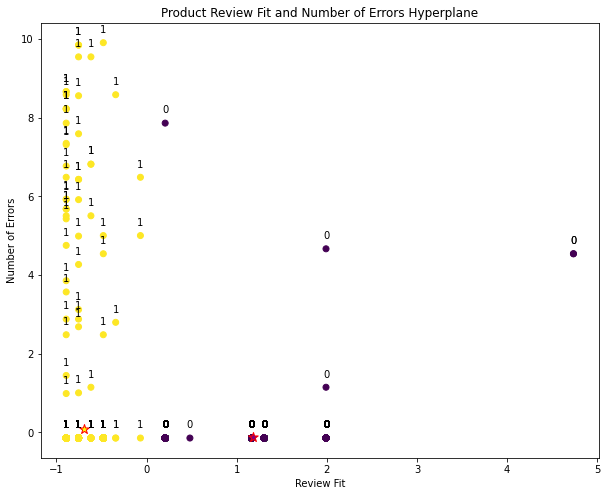

In [132]:
# Initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(10, 8))
# Create a plot
ax = fig.add_subplot(1, 1, 1)
plt.scatter(X,Y, c=labels)
i=0
for x,y in zip(X,Y):

    label = labels[i]

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    i+=1
plt.scatter(centroids[0][4],centroids[0][11], c='purple', edgeColors='red', marker='*', s=100)
plt.scatter(centroids[1][4],centroids[1][11], c='yellow', edgeColors='red', marker='*', s=100)
plt.xlabel('Review Fit')
plt.ylabel('Number of Errors')
plt.title('Product Review Fit and Number of Errors Hyperplane')

This plane seems to indicate, that the value of interest is the product-review fit. If the review seems to not be correlated to the product description, then it is probably a fake review

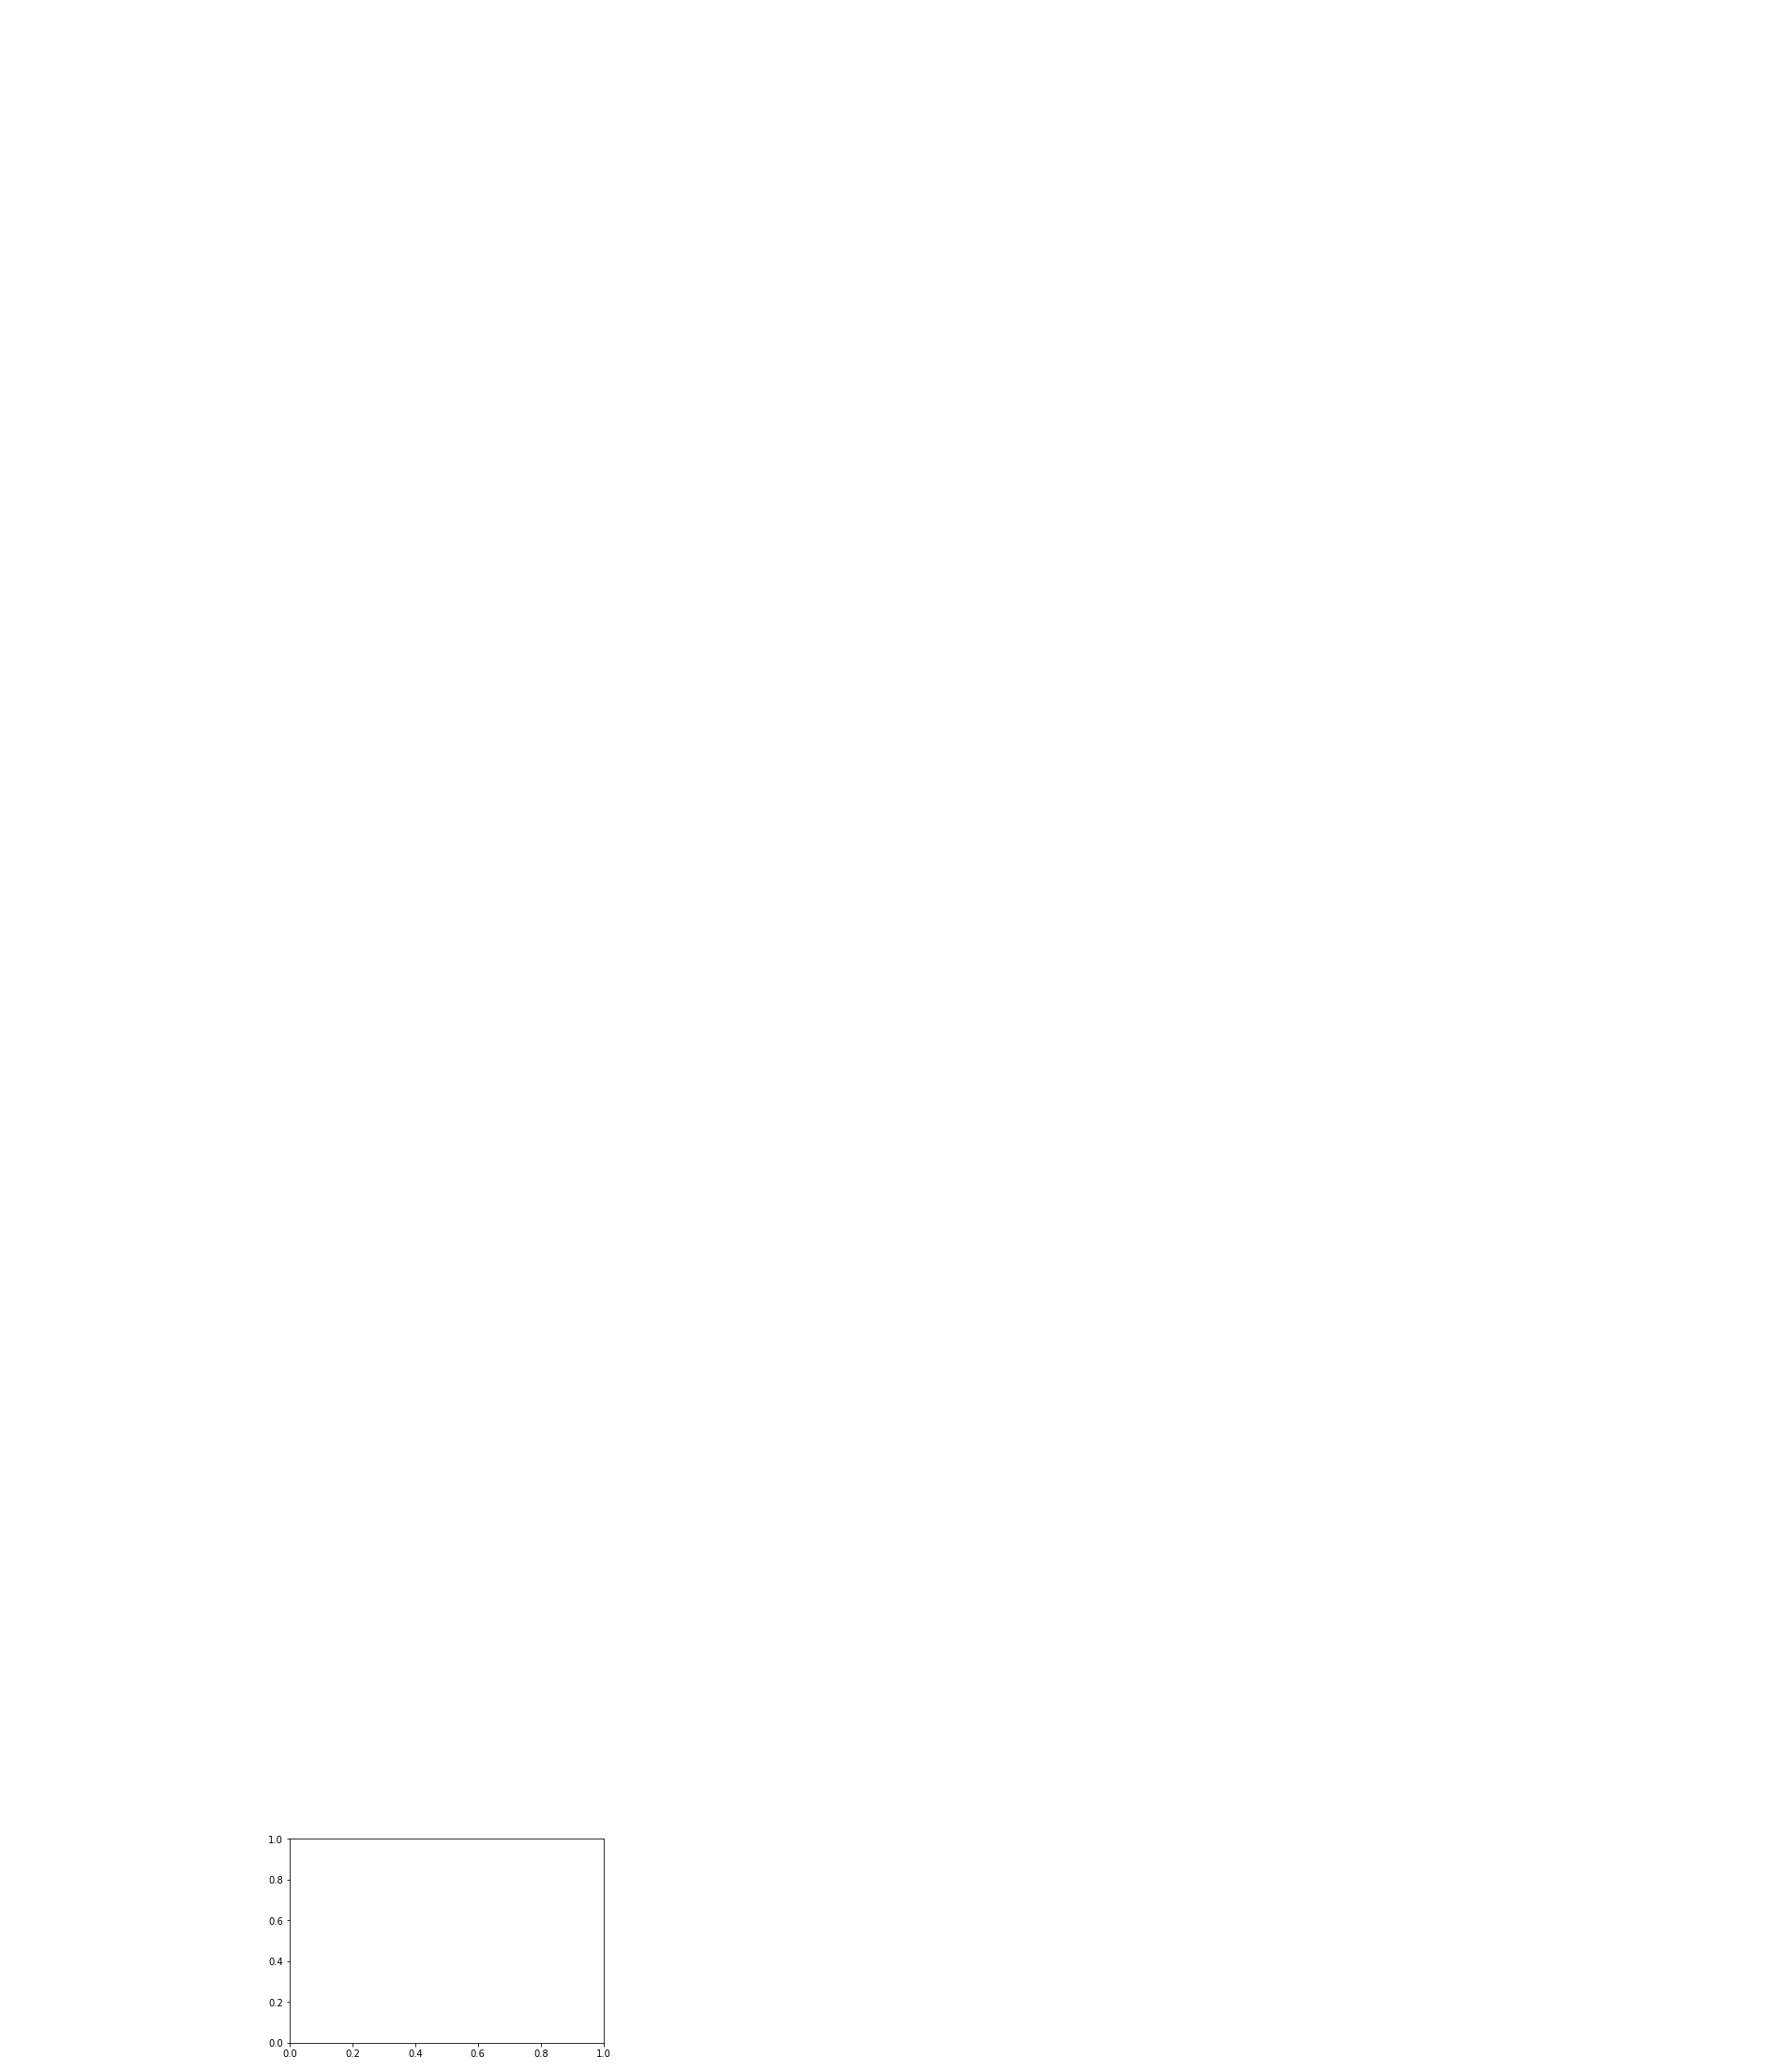